In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/kaggle/input/force-brute/samples.csv')

# Separate features and labels
X = df.drop(columns=['CLASS', 'SRC_IP', 'DST_IP'])  # Drop non-numeric columns and 'CLASS'
y = df['CLASS']

# Ensure that only numeric columns are selected
X = X.select_dtypes(include=[np.number])  # Keep only numeric columns

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape data to match the input shape for CNN (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Data Augmentation Functions

def add_noise(X, noise_factor=0.1):
    """Add random noise to the data."""
    noise = np.random.normal(0, noise_factor, X.shape)
    return X + noise

def time_shift(X, shift_max=1):
    """Randomly shift the time steps in the data."""
    shift = np.random.randint(-shift_max, shift_max, X.shape[0])
    X_shifted = np.array([np.roll(x, s) for x, s in zip(X, shift)])
    return X_shifted

def jitter_data(X, jitter_factor=0.1):
    """Jitter the data by a small amount."""
    return X + np.random.uniform(-jitter_factor, jitter_factor, X.shape)

def random_scaling(X, scale_factor=0.1):
    """Scale the data by a random factor."""
    scale = 1 + np.random.uniform(-scale_factor, scale_factor, X.shape)
    return X * scale

def random_rotation(X, rotation_factor=0.1):
    """Randomly rotate the data (for 2D or 3D data)."""
    # For simplicity, this is shown for 2D data (features, samples)
    angle = np.random.uniform(-rotation_factor, rotation_factor)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    return np.dot(X.reshape(-1, 2), rotation_matrix).reshape(X.shape)

def random_shuffling(X):
    """Shuffle the time steps in each sequence."""
    X_shuffled = np.array([np.random.permutation(x) for x in X])
    return X_shuffled

def multiplicative_noise(X, noise_factor=0.1):
    """Add multiplicative noise to the data."""
    noise = 1 + np.random.normal(0, noise_factor, X.shape)
    return X * noise

# Apply augmentation to the training data
X_train_noisy = add_noise(X_train)
X_train_shifted = time_shift(X_train)
X_train_jittered = jitter_data(X_train)
X_train_scaled = random_scaling(X_train)
X_train_rotated = random_rotation(X_train)  # Only for 2D/3D data, otherwise remove this function
X_train_shuffled = random_shuffling(X_train)
X_train_multiplicative = multiplicative_noise(X_train)

# Combine the augmented data with the original data to create a larger training set
X_train_augmented = np.concatenate([X_train, X_train_noisy, X_train_shifted, X_train_jittered,
                                    X_train_scaled, X_train_rotated, X_train_shuffled, X_train_multiplicative], axis=0)
y_train_augmented = np.concatenate([y_train, y_train, y_train, y_train, y_train, y_train, y_train, y_train], axis=0)

# Verify the new shape of the augmented data
print(f'Original X_train shape: {X_train.shape}')
print(f'Augmented X_train shape: {X_train_augmented.shape}')


Original X_train shape: (53975, 52, 1)
Augmented X_train shape: (431800, 52, 1)


In [8]:
# Build the CNN model
model = Sequential()

# Add 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer (number of classes for classification)
model.add(Dense(units=len(y_train.unique()), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(X_train_augmented, y_train_augmented, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 50, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 205,442 (802.51 KB)

 Trainable params: 205,442 (802.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9601 - loss: 0.1129 - val_accuracy: 0.9950 - val_loss: 0.0154
Epoch 2/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9719 - loss: 0.0727 - val_accuracy: 0.9967 - val_loss: 0.0108
Epoch 3/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9734 - loss: 0.0680 - val_accuracy: 0.9976 - val_loss: 0.0086
Epoch 4/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9742 - loss: 0.0646 - val_accuracy: 0.9975 - val_loss: 0.0093
Epoch 5/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9748 - loss: 0.0632 - val_accuracy: 0.9976 - val_loss: 0.0085
Epoch 6/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 0.9750 - loss: 0.0622 - val_accuracy: 0.9977 - val_loss: 0.0075
Epoch 7/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.9758 - loss: 0.0607 - val_accuracy: 0.9981 - val_loss: 0.0058
Epoch 8/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 

In [9]:
# Build the LSTM model
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

# Add LSTM layer
model_lstm.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), return_sequences=False))

# Add dense layers
model_lstm.add(Dense(units=128, activation='relu'))
model_lstm.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output layer (number of classes for classification)
model_lstm.add(Dense(units=len(y_train.unique()), activation='softmax'))

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

# Train the model
history_lstm = model_lstm.fit(X_train_augmented, y_train_augmented, epochs=10, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,474 (99.51 KB)

 Trainable params: 25,474 (99.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.9322 - loss: 0.1778 - val_accuracy: 0.9938 - val_loss: 0.0203
Epoch 2/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.9712 - loss: 0.0735 - val_accuracy: 0.9957 - val_loss: 0.0158
Epoch 3/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.9768 - loss: 0.0589 - val_accuracy: 0.9960 - val_loss: 0.0155
Epoch 4/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.9793 - loss: 0.0515 - val_accuracy: 0.9927 - val_loss: 0.0204
Epoch 5/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9806 - loss: 0.0473 - val_accuracy: 0.9967 - val_loss: 0.0138
Epoch 6/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9821 - loss: 0.0440 - val_accuracy: 0.9927 - val_loss: 0.0200
Epoch 7/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 0.9838 - loss: 0.0411 - val_accuracy: 0.9975 - val_loss: 0.0098
Epoch 8/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - accuracy: 

In [16]:
import keras_tuner as kt
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Define the function to build the model with tunable hyperparameters
def build_model(hp):
    model = Sequential()

    # Add CNN layers with tunable hyperparameters
    model.add(Conv1D(filters=hp.Choice('filters', values=[32, 64]),  # Reduced range
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),  # Smaller options
                     activation='relu', 
                     input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=hp.Choice('pool_size', values=[2, 3])))  # Fewer choices

    # Add LSTM layer with tunable hyperparameters
    model.add(LSTM(units=hp.Choice('lstm_units', values=[32, 64]), return_sequences=False))

    # Add dense layers with tunable hyperparameters
    model.add(Dense(units=hp.Choice('dense_units', values=[64, 128]), activation='relu'))
    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.3, 0.5])))  # Fewer choices

    # Output layer
    model.add(Dense(units=len(y_train.unique()), activation='softmax'))

    # Compile the model with a tunable optimizer
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-3])), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Initialize the KerasTuner object (Hyperband with fewer iterations and epochs)
tuner = kt.Hyperband(
    build_model, 
    objective='val_accuracy', 
    max_epochs=5,  # Fewer epochs for faster search
    hyperband_iterations=1,  # Reduced iterations
    directory='my_dir', 
    project_name='cnn_lstm_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train_augmented, y_train_augmented, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# Get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model with the best hyperparameters
history_cnn_lstm = best_model.fit(X_train_augmented, y_train_augmented, 
                                  epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Print the model summary
best_model.summary()


Trial 10 Complete [00h 05m 10s]
val_accuracy: 0.9969615936279297

Best val_accuracy So Far: 0.9977768063545227
Total elapsed time: 00h 33m 15s
Epoch 1/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 63s 5ms/step - accuracy: 0.9510 - loss: 0.1297 - val_accuracy: 0.9950 - val_loss: 0.0190
Epoch 2/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9778 - loss: 0.0560 - val_accuracy: 0.9961 - val_loss: 0.0145
Epoch 3/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9807 - loss: 0.0480 - val_accuracy: 0.9975 - val_loss: 0.0117
Epoch 4/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9831 - loss: 0.0424 - val_accuracy: 0.9980 - val_loss: 0.0094
Epoch 5/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9847 - loss: 0.0381 - val_accuracy: 0.9976 - val_loss: 0.0099
Epoch 6/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - accuracy: 0.9862 - loss: 0.0352 - val_accuracy: 0.9979 - val_loss: 0.0113
Epoch 7/10
13494/13494 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 48, 64)              │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,096 (441.79 KB)

 Trainable params: 37,698 (147.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 75,398 (294.53 KB)


Meilleurs hyperparamètres trouvés:
  filters kernel_size pool_size lstm_units dense_units dropout_rate  \
7      64           5         3         64          64          0.3   

  learning_rate  
7         0.001  


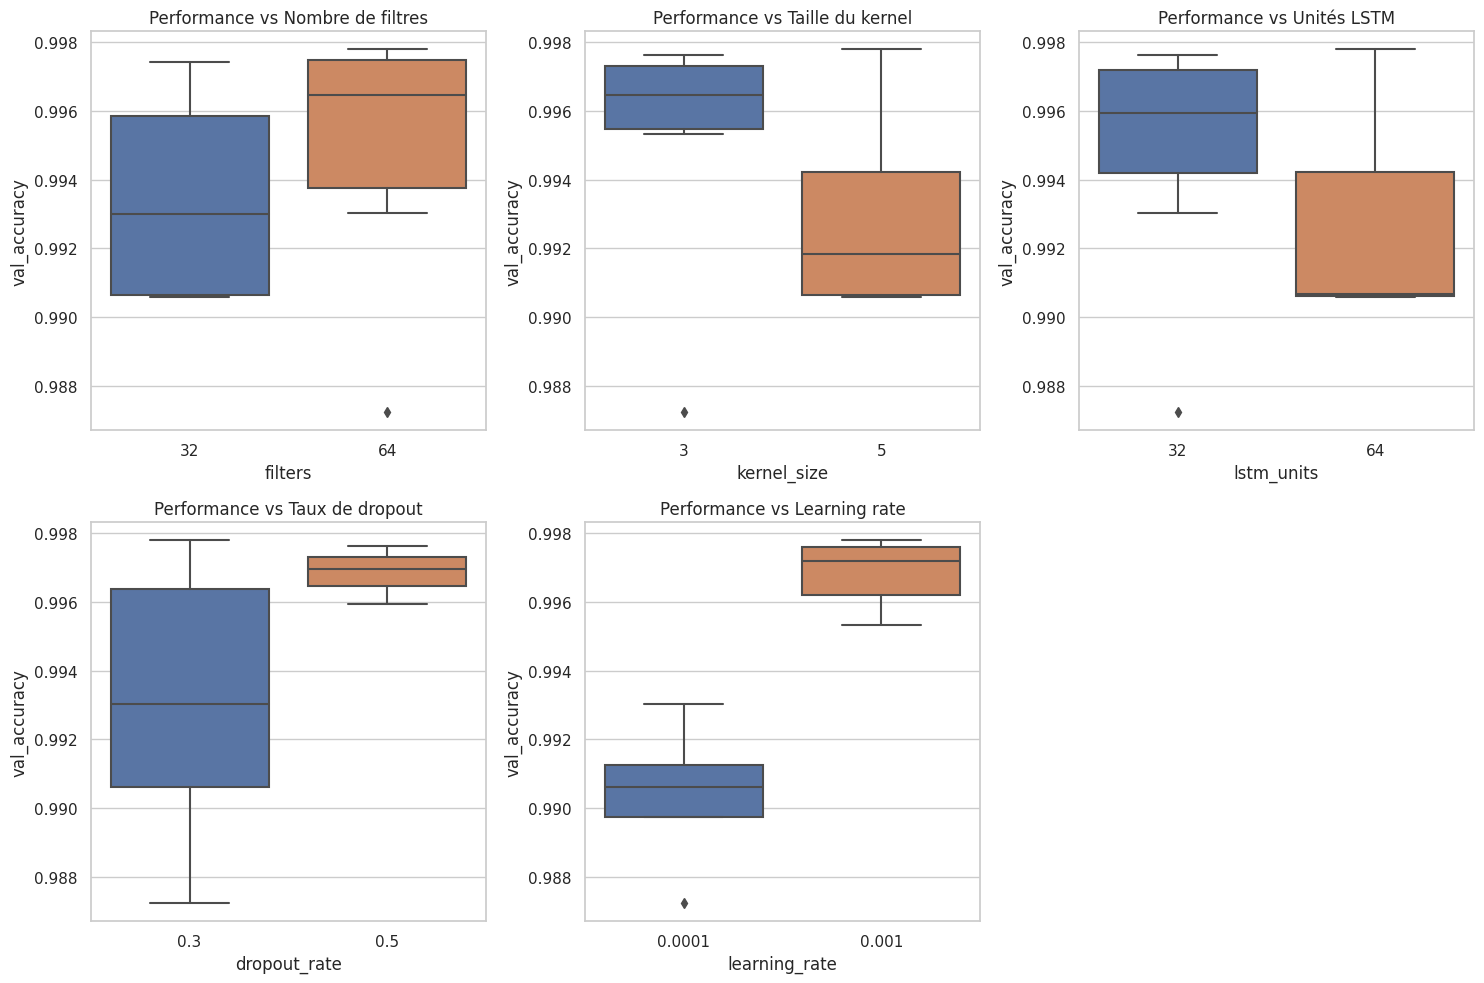

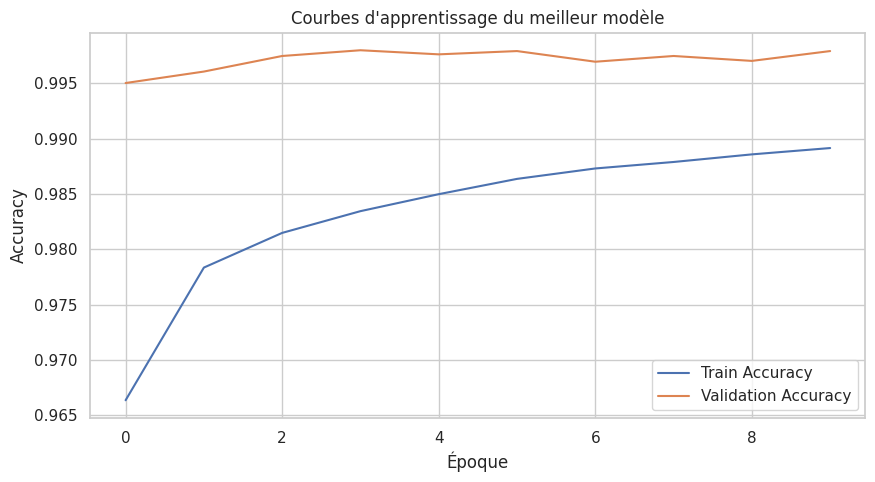


Analyse statistique des performances par hyperparamètre:

filters:
             mean       std  count
filters                           
32       0.993497  0.003423      4
64       0.994763  0.004071      6

kernel_size:
                 mean       std  count
kernel_size                           
3            0.995084  0.003936      6
5            0.993015  0.003371      4

lstm_units:
                mean       std  count
lstm_units                           
32          0.994791  0.003676      7
64          0.993009  0.004129      3

dropout_rate:
                  mean       std  count
dropout_rate                           
0.3           0.993150  0.003912      7
0.5           0.996838  0.000859      3

learning_rate:
                   mean       std  count
learning_rate                           
0.0001         0.990385  0.002376      4
0.0010         0.996838  0.000995      6


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import History

def analyze_tuning_results(tuner, history: History):
    # Récupérer tous les essais et leurs métriques
    trials_df = pd.DataFrame([
        {
            'trial_id': trial.trial_id,
            'val_accuracy': trial.metrics.get_best_value('val_accuracy'),
            'filters': trial.hyperparameters.get('filters'),
            'kernel_size': trial.hyperparameters.get('kernel_size'),
            'pool_size': trial.hyperparameters.get('pool_size'),
            'lstm_units': trial.hyperparameters.get('lstm_units'),
            'dense_units': trial.hyperparameters.get('dense_units'),
            'dropout_rate': trial.hyperparameters.get('dropout_rate'),
            'learning_rate': trial.hyperparameters.get('learning_rate')
        }
        for trial in tuner.oracle.trials.values()
    ])

    # 1. Tableau récapitulatif des meilleurs hyperparamètres
    print("\nMeilleurs hyperparamètres trouvés:")
    best_trial = trials_df.loc[trials_df['val_accuracy'].idxmax()]
    print(best_trial.to_frame().T[['filters', 'kernel_size', 'pool_size', 'lstm_units', 
                                  'dense_units', 'dropout_rate', 'learning_rate']])

    # 2. Visualisation de l'influence des hyperparamètres
    fig = plt.figure(figsize=(15, 10))
    
    # 2.1 Distribution des performances selon les filtres CNN
    plt.subplot(2, 3, 1)
    sns.boxplot(x='filters', y='val_accuracy', data=trials_df)
    plt.title('Performance vs Nombre de filtres')
    
    # 2.2 Distribution des performances selon la taille du kernel
    plt.subplot(2, 3, 2)
    sns.boxplot(x='kernel_size', y='val_accuracy', data=trials_df)
    plt.title('Performance vs Taille du kernel')
    
    # 2.3 Distribution des performances selon les unités LSTM
    plt.subplot(2, 3, 3)
    sns.boxplot(x='lstm_units', y='val_accuracy', data=trials_df)
    plt.title('Performance vs Unités LSTM')
    
    # 2.4 Distribution des performances selon le dropout
    plt.subplot(2, 3, 4)
    sns.boxplot(x='dropout_rate', y='val_accuracy', data=trials_df)
    plt.title('Performance vs Taux de dropout')
    
    # 2.5 Distribution des performances selon le learning rate
    plt.subplot(2, 3, 5)
    sns.boxplot(x='learning_rate', y='val_accuracy', data=trials_df)
    plt.title('Performance vs Learning rate')
    
    plt.tight_layout()
    plt.show()

    # 3. Courbes d'apprentissage du meilleur modèle
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Courbes d\'apprentissage du meilleur modèle')
    plt.xlabel('Époque')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Analyse statistique des hyperparamètres
    print("\nAnalyse statistique des performances par hyperparamètre:")
    for param in ['filters', 'kernel_size', 'lstm_units', 'dropout_rate', 'learning_rate']:
        print(f"\n{param}:")
        print(trials_df.groupby(param)['val_accuracy'].agg(['mean', 'std', 'count']))

# Utilisation de la fonction
analyze_tuning_results(tuner, history_cnn_lstm)

In [22]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Filters: {best_hps.get('filters')}")
print(f"Kernel size: {best_hps.get('kernel_size')}")
print(f"Pool size: {best_hps.get('pool_size')}")
print(f"LSTM units: {best_hps.get('lstm_units')}")
print(f"Dense units: {best_hps.get('dense_units')}")
print(f"Dropout rate: {best_hps.get('dropout_rate')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")


Best Hyperparameters:
Filters: 64
Kernel size: 5
Pool size: 3
LSTM units: 64
Dense units: 64
Dropout rate: 0.3
Learning rate: 0.001


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report (Hybrid CNN + LSTM):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11150
           1       0.99      1.00      0.99      2344

    accuracy                           1.00     13494
   macro avg       1.00      1.00      1.00     13494
weighted avg       1.00      1.00      1.00     13494

Accuracy (Hybrid CNN + LSTM): 0.9979
Loss (Hybrid CNN + LSTM): 0.0132


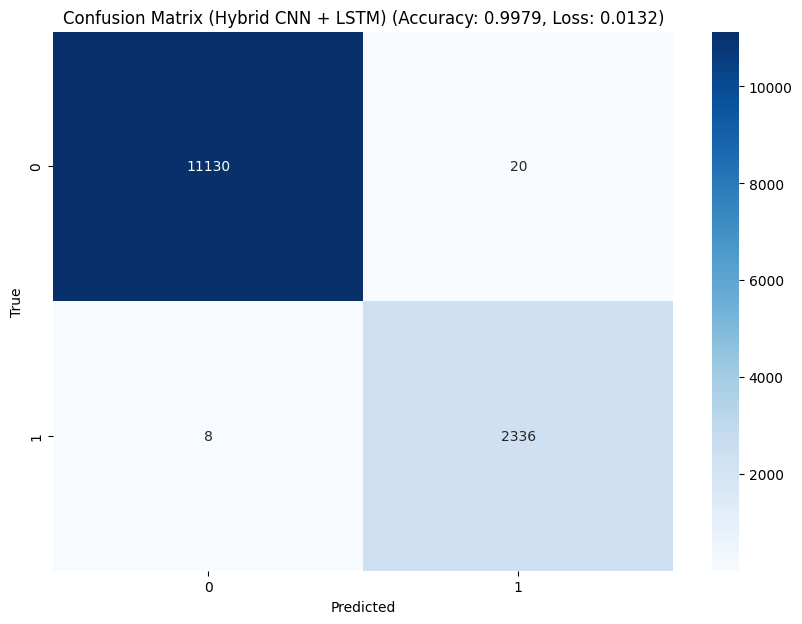

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on the test set using the best model from KerasTuner
y_pred_cnn_lstm = best_model.predict(X_test)
y_pred_classes_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)

# Compute the classification report for Hybrid CNN + LSTM
print("Classification Report (Hybrid CNN + LSTM):\n", classification_report(y_test, y_pred_classes_cnn_lstm))

# Compute accuracy for Hybrid CNN + LSTM
accuracy_cnn_lstm = accuracy_score(y_test, y_pred_classes_cnn_lstm)
print(f"Accuracy (Hybrid CNN + LSTM): {accuracy_cnn_lstm:.4f}")

# Compute the loss using the evaluate method of the model
loss_cnn_lstm, _ = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss (Hybrid CNN + LSTM): {loss_cnn_lstm:.4f}")

# Compute confusion matrix for Hybrid CNN + LSTM
cm_cnn_lstm = confusion_matrix(y_test, y_pred_classes_cnn_lstm)

# Plot the confusion matrix for Hybrid CNN + LSTM
plt.figure(figsize=(10, 7))
sns.heatmap(cm_cnn_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=y_train.unique(), yticklabels=y_train.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Hybrid CNN + LSTM) (Accuracy: {accuracy_cnn_lstm:.4f}, Loss: {loss_cnn_lstm:.4f})')
plt.show()


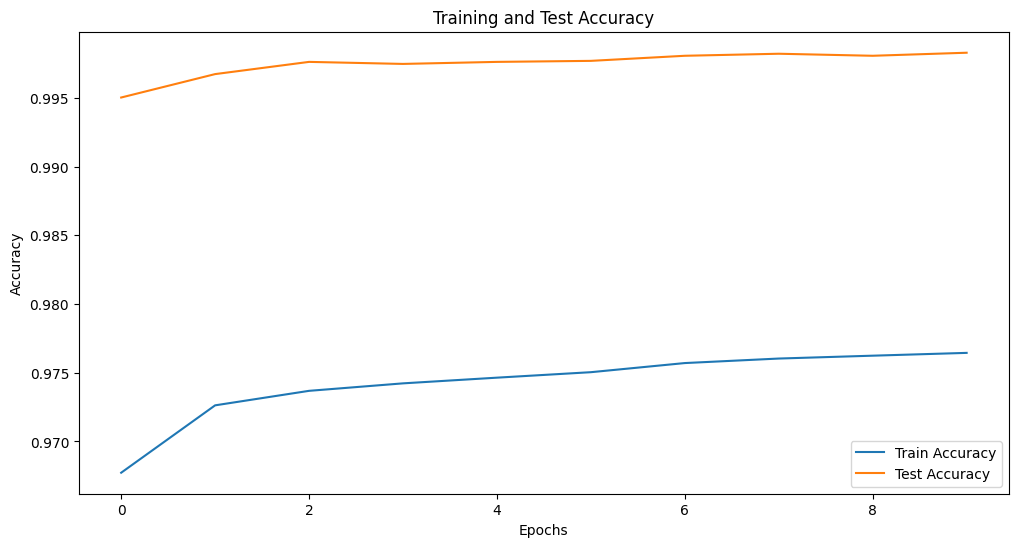

In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

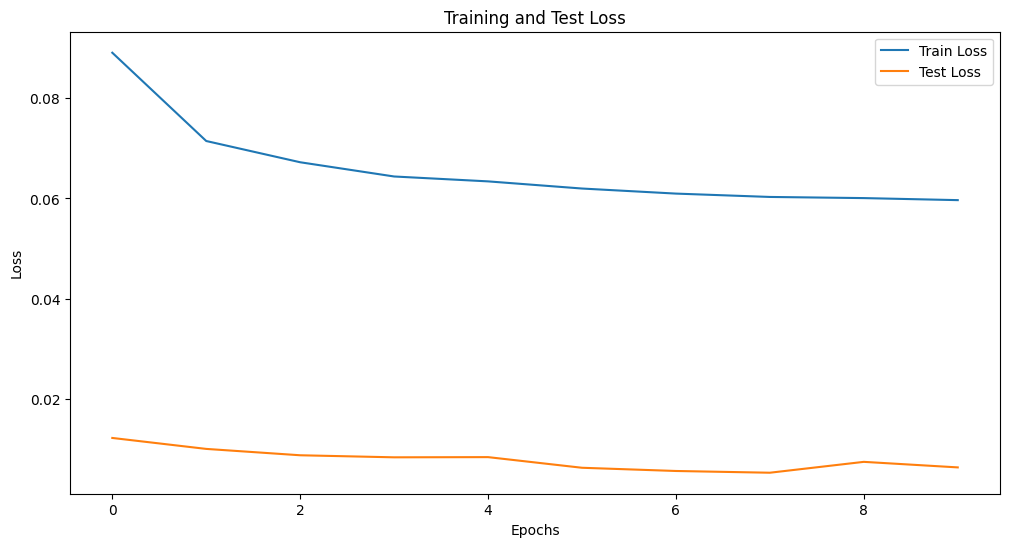

In [12]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

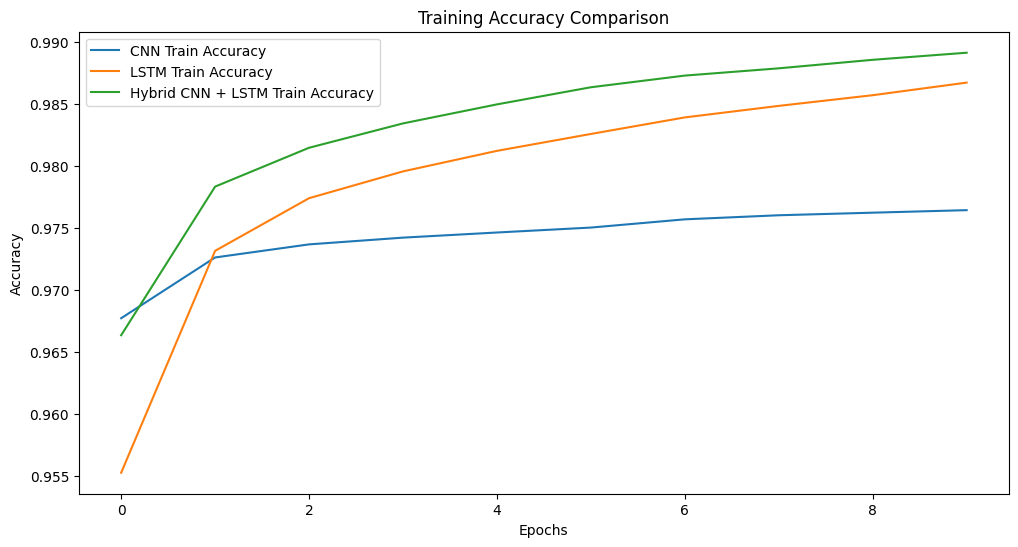

In [20]:
# Plot training accuracy for CNN, LSTM, and Hybrid CNN + LSTM in one plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='CNN Train Accuracy')
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(history_cnn_lstm.history['accuracy'], label='Hybrid CNN + LSTM Train Accuracy')

# Title and labels
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


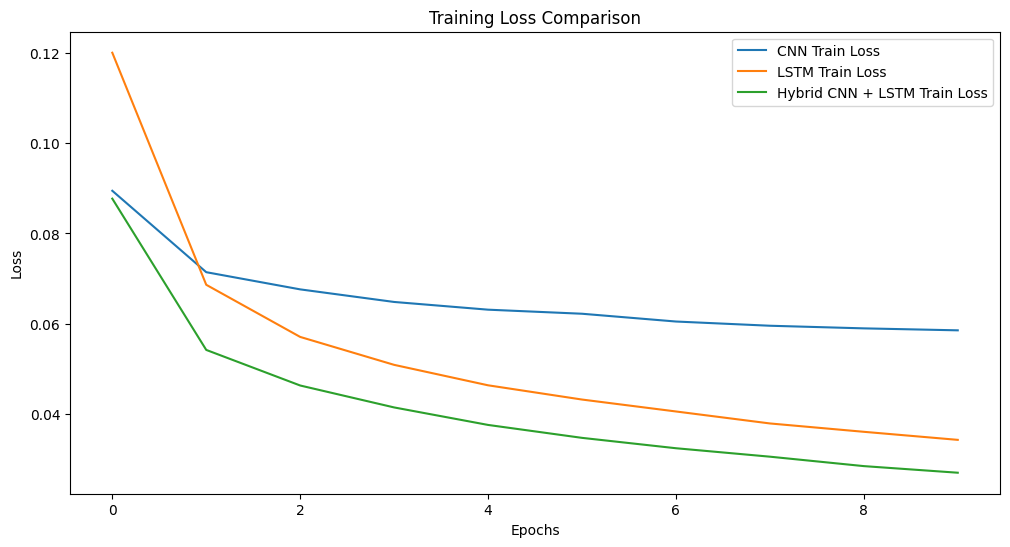

In [21]:
# Plot training loss for CNN, LSTM, and Hybrid CNN + LSTM in one plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='CNN Train Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_cnn_lstm.history['loss'], label='Hybrid CNN + LSTM Train Loss')

# Title and labels
plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
